# Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

import numpy as np
from collections import defaultdict
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.trainers import BpeTrainer
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import psutil

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

corpus = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").text.split("\n")

print(corpus[0:100])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '', 'All:', 'Resolved. resolved.', '', 'First Citizen:', 'First, you know Caius Marcius is chief enemy to the people.', '', 'All:', "We know't, we know't.", '', 'First Citizen:', "Let us kill him, and we'll have corn at our own price.", "Is't a verdict?", '', 'All:', "No more talking on't; let it be done: away, away!", '', 'Second Citizen:', 'One word, good citizens.', '', 'First Citizen:', 'We are accounted poor citizens, the patricians good.', 'What authority surfeits on would relieve us: if they', 'would yield us but the superfluity, while it were', 'wholesome, we might guess they relieved us humanely;', 'but they think we are too dear: the leanness that', 'afflicts us, the object of our misery, is as an', 'inventory to particularise their abundance; our', 'sufferance is a gain to them Let us revenge this with', 

# Data Preperation

### Tokenization

In [ ]:
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

In [ ]:
# Compute frequencies of each word
word_freqs = defaultdict(int)

for text in corpus:
    new_words = text.split()
    for word in new_words:
        word_freqs[word] += 1

print("Word Frequencies:\n",word_freqs)

# Create base vocabulary
alphabet = []

for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()

print("\nVocabulary:\n",alphabet)

vocab = ["<|endoftext|>"] + alphabet.copy()

# Split words into individual characters
splits = {word: [c for c in word] for word in word_freqs.keys()}

Word Frequencies:
 defaultdict(<class 'int'>, {'First': 235, 'Citizen:': 98, 'Before': 31, 'we': 658, 'proceed': 8, 'any': 179, 'further,': 4, 'hear': 176, 'me': 1111, 'speak.': 38, 'All:': 19, 'Speak,': 6, 'You': 319, 'are': 670, 'all': 676, 'resolved': 9, 'rather': 58, 'to': 3923, 'die': 62, 'than': 341, 'famish?': 1, 'Resolved.': 1, 'resolved.': 1, 'First,': 20, 'you': 2130, 'know': 281, 'Caius': 14, 'Marcius': 30, 'is': 1768, 'chief': 6, 'enemy': 18, 'the': 5437, 'people.': 12, 'We': 182, "know't,": 1, "know't.": 3, 'Let': 125, 'us': 262, 'kill': 43, 'him,': 168, 'and': 3678, "we'll": 46, 'have': 1280, 'corn': 6, 'at': 492, 'our': 702, 'own': 137, 'price.': 1, "Is't": 12, 'a': 2610, 'verdict?': 1, 'No': 94, 'more': 395, 'talking': 4, "on't;": 2, 'let': 312, 'it': 1189, 'be': 1489, 'done:': 11, 'away,': 15, 'away!': 14, 'Second': 149, 'One': 45, 'word,': 23, 'good': 504, 'citizens.': 2, 'accounted': 2, 'poor': 129, 'citizens,': 6, 'patricians': 4, 'good.': 13, 'What': 379, 'authorit

In [ ]:
def compute_pair_freqs(splits):
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            pair_freqs[pair] += freq
    return pair_freqs

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

vocab_size = 300
merges = {}

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

print("Merges:\n",merges)
print("Final Vocabulary:\n",vocab)

del word_freqs, splits

Merges:
 {('t', 'h'): 'th', ('o', 'u'): 'ou', ('e', 'r'): 'er', ('i', 'n'): 'in', ('a', 'n'): 'an', ('th', 'e'): 'the', ('o', 'r'): 'or', ('i', 's'): 'is', ('e', 'n'): 'en', ('a', 'r'): 'ar', ('a', 't'): 'at', ('o', 'n'): 'on', ('s', 't'): 'st', ('l', 'l'): 'll', ('m', 'e'): 'me', ('t', 'o'): 'to', ('an', 'd'): 'and', ('h', 'e'): 'he', ('y', 'ou'): 'you', ('e', 's'): 'es', ('n', 'o'): 'no', ('s', 'e'): 'se', ('h', 'a'): 'ha', ('r', 'e'): 're', ('o', 'f'): 'of', ('v', 'e'): 've', ('i', 't'): 'it', ('in', 'g'): 'ing', ('b', 'e'): 'be', ('l', 'e'): 'le', ('w', 'i'): 'wi', ('m', 'y'): 'my', ('h', 'i'): 'hi', ('o', 'w'): 'ow', ('c', 'e'): 'ce', ('f', 'or'): 'for', ('a', 'y'): 'ay', ('a', 's'): 'as', ('c', 'h'): 'ch', ('n', 'd'): 'nd', ('er', 'e'): 'ere', ('l', 'd'): 'ld', ('i', 'r'): 'ir', ('e', 'd'): 'ed', ('u', 't'): 'ut', ('r', 'o'): 'ro', ('no', 't'): 'not', ('l', 'i'): 'li', ('d', 'e'): 'de', ('w', 'e'): 'we', ('h', 'at'): 'hat', ('th', 'at'): 'that', ('g', 'h'): 'gh', ('A', 'nd'): 'An

In [ ]:
# Tokenize entire corpus
def tokenize(text):
    pre_tokenize_result = [(word, None) for word in text.split()]
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

data = []
for line in corpus:
    data.extend(tokenize(line))
print("\nFirst 50 symbols:", data[:50])

vocab = sorted(set(data))
token_to_id = {w: i for i, w in enumerate(vocab)}
id_to_token = {i: w for i, w in enumerate(vocab)}

vocab_size = len(vocab)

print("\nVocabulary size:",len(vocab))
print(f"Total tokens: {len(data):,}")
print("Sample tokens:", list(token_to_id.items())[:10])

data = [token_to_id[token] for token in data]
print("\nFirst 50 token IDs:", data[:50])


First 50 symbols: ['F', 'ir', 'st', 'C', 'it', 'i', 'z', 'en', ':', 'B', 'e', 'for', 'e', 'we', 'p', 'ro', 'ce', 'ed', 'an', 'y', 'f', 'ur', 'ther', ',', 'he', 'ar', 'me', 's', 'pe', 'ak', '.', 'A', 'll', ':', 'S', 'pe', 'ak', ',', 's', 'pe', 'ak', '.', 'F', 'ir', 'st', 'C', 'it', 'i', 'z', 'en']

Vocabulary size: 298
Total tokens: 495,887
Sample tokens: [('!', 0), ('$', 1), ('&', 2), ("'", 3), ("'d", 4), ("'ll", 5), ("'s", 6), ("'t", 7), (',', 8), ('-', 9)]

First 50 token IDs: [32, 166, 249, 24, 168, 155, 297, 121, 13, 22, 117, 134, 117, 284, 221, 231, 104, 120, 82, 293, 131, 275, 263, 8, 146, 85, 190, 235, 222, 78, 11, 16, 182, 13, 57, 222, 78, 8, 235, 222, 78, 11, 32, 166, 249, 24, 168, 155, 297, 121]


### Sequence Formatting & Data Split

In [ ]:
block_size = 50
batch_size = 128

data_ids = torch.tensor(data, dtype=torch.long)

split_idx = int(0.8 * len(data_ids))  # 80% split index
train_ids = data_ids[:split_idx]
val_ids   = data_ids[split_idx:]

def get_batch(source, batch_size, block_size, device):
    """Return one random mini-batch."""
    ix = torch.randint(0, len(source) - block_size - 1, (batch_size,))
    x = torch.stack([source[i:i+block_size] for i in ix])
    y = torch.stack([source[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Show one example input-target pair
example_x, example_y = get_batch(train_ids, batch_size=1, block_size=10, device='cpu')

print("Example Input IDs: ", example_x[0].tolist())
print("Example Target IDs:", example_y[0].tolist())

Example Input IDs:  [113, 193, 136, 230, 117, 131, 270, 270, 202, 194]
Example Target IDs: [193, 136, 230, 117, 131, 270, 270, 202, 194, 106]


### Token Embedding

In [ ]:
# Self-attention with a causal mask
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = Q @ K.transpose(-2, -1) / (d_model ** 0.5)

        # Causal mask
        mask = torch.tril(torch.ones(seq_len, seq_len)).to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = torch.nan_to_num(attn_weights, 0.0)

        output = attn_weights @ V
        return output, attn_weights

# RMS Norm
class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(d_model))
    def forward(self, x):
        norm = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return self.scale * (x / norm)

# Feed-forward network with residual connections
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.norm1 = RMSNorm(d_model)
        self.attn = SelfAttention(d_model)
        self.norm2 = RMSNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x):
        attn_out, attn_weights = self.attn(self.norm1(x))
        x = x + attn_out  # Residual connection

        ffn_out = self.ffn(self.norm2(x))
        x = x + ffn_out  # Residual connection

        return x, attn_weights

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, d_ff, max_seq_len=128):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model) # Token embedding
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02) # Position embedding

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, d_ff) for _ in range(n_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x, return_attn: bool = False):
        seq_len = x.shape[1]
        x = self.token_embedding(x) + self.pos_encoding[:, :seq_len, :]

        all_attn = [] if return_attn else None
        for block in self.blocks:
            x, attn = block(x)
            if return_attn:
                all_attn.append(attn)

        logits = self.output_layer(x)
        return (logits, all_attn) if return_attn else (logits, None)


# Tiny Transformer Implementation

### Model Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.time()

d_model = 64 # Hidden size
n_layers = 2 # Transformer blocks
d_ff = 256
learning_rate = 0.001
n_epochs = 100
batch_size = 128
max_len = 128

model = TinyTransformer(vocab_size, d_model, n_layers, d_ff, max_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

train_losses, val_losses, train_accs = [], [], []
best_loss = float('inf')
best_epoch = 0

steps_per_epoch = max(1, len(train_ids) // (batch_size * block_size))

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0

    for _ in range(steps_per_epoch):
        batch_X, batch_Y = get_batch(train_ids, batch_size, block_size, device)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits, _ = model(batch_X)
            loss = criterion(logits.view(-1, logits.size(-1)), batch_Y.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        preds = logits[:, -1, :].argmax(dim=1)
        acc = (preds == batch_Y[:, -1]).float().mean().item()

        epoch_loss += loss.item()
        epoch_acc += acc

    train_losses.append(epoch_loss / steps_per_epoch)
    train_accs.append(epoch_acc / steps_per_epoch)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for _ in range(50):
            bx, by = get_batch(val_ids, batch_size, block_size, device)
            logits, _ = model(bx)
            val_loss += criterion(logits.view(-1, logits.size(-1)), by.view(-1)).item()
    val_loss /= 50
    val_losses.append(val_loss)

    val_ppl = np.exp(val_loss)

    # Track best epoch
    if epoch == 0 or val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch + 1
        best_state = model.state_dict()
        best_train_loss = train_losses[-1]

model.load_state_dict(best_state)

best_ppl = np.exp(best_loss)
print(
    f"\nBest Epoch: {best_epoch} "
    f"| Train Loss = {best_train_loss:.4f} "
    f"| Val Loss = {best_loss:.4f} "
    f"| PPL = {best_ppl:.2f}"
)

end_time = time.time()
total_runtime = end_time - start_time

if device.type == "cuda":
    peak_mem = torch.cuda.max_memory_allocated(device) / 1e9
else:
    peak_mem = psutil.Process().memory_info().rss / 1e9

print(f"\nTotal Training Time: {total_runtime:.2f} seconds")
print(f"Peak Memory Used: {peak_mem:.2f} GB")


/tmp/ipython-input-3029857389.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-3029857389.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



Best Epoch: 88 | Train Loss = 3.0949 | Val Loss = 3.8957 | PPL = 49.19

Total Training Time: 1133.56 seconds
Peak Memory Used: 1.03 GB


### Visualizations

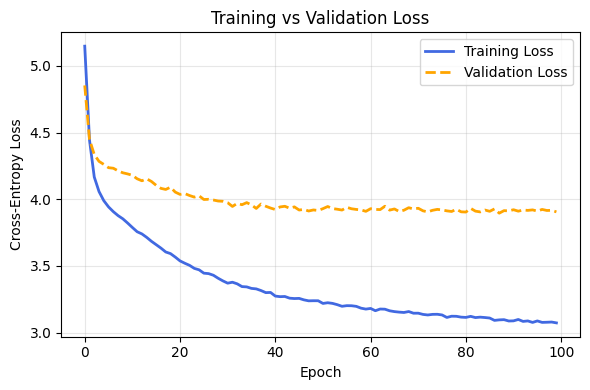

In [ ]:
# Training and validation loss curves over epochs
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title("Training vs Validation Loss", fontsize=12)
plt.xlabel("Epoch", fontsize=10)
plt.ylabel("Cross-Entropy Loss", fontsize=10)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

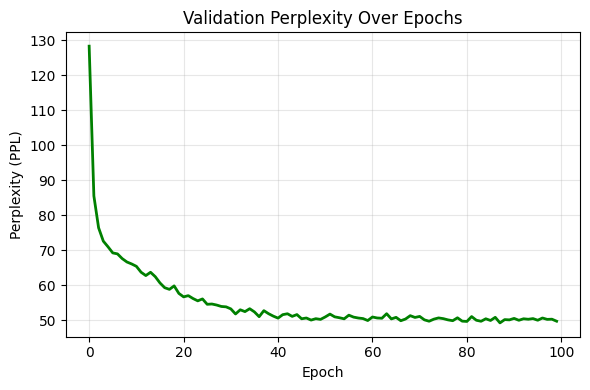

In [ ]:
# Perplexity over epochs
ppls = np.exp(np.array(val_losses))

plt.figure(figsize=(6,4))
plt.plot(ppls, label='Validation Perplexity', color='green', linewidth=2)
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity (PPL)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

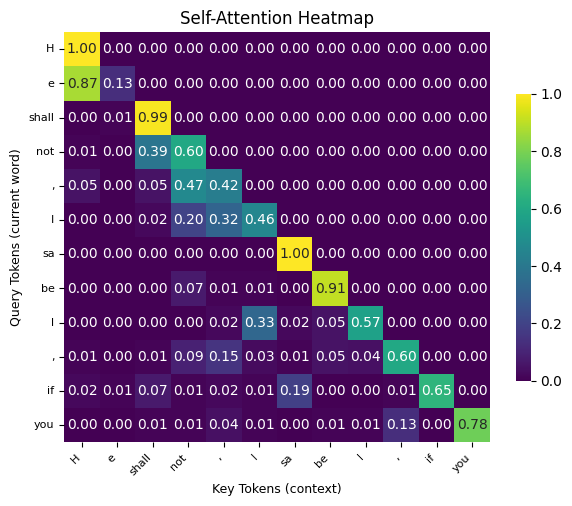

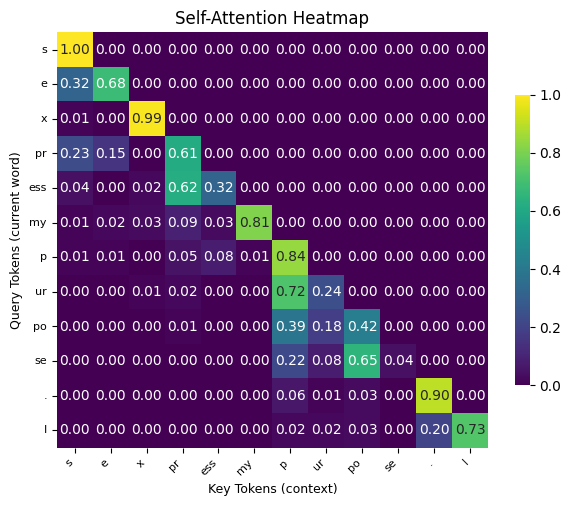

In [ ]:
# Self-attention heatmaps
model.eval()

starts = [10,100]

for start in starts:
    # Use a short window of validation tokens
    x_sample = val_ids[start:start+block_size].unsqueeze(0).to(device)

    with torch.no_grad():
        logits, attn_list = model(x_sample, return_attn=True)

    tokens = [id_to_token[int(i)] for i in x_sample[0].tolist()]
    attn = attn_list[0][0].cpu().numpy()

    max_tokens = 12
    attn = attn[:max_tokens, :max_tokens]
    tokens = tokens[:max_tokens]
    attn_rounded = np.round(attn, 2)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        attn_rounded, cmap="viridis",
        annot=True, fmt=".2f",
        xticklabels=tokens, yticklabels=tokens,
        cbar_kws={"shrink": 0.7}
    )
    plt.title("Self-Attention Heatmap", fontsize=12)
    plt.xlabel("Key Tokens (context)", fontsize=9)
    plt.ylabel("Query Tokens (current word)", fontsize=9)
    plt.xticks(rotation=45, ha="right", fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout(pad=0.5)
    plt.show()

In [ ]:

def generate_text(model, tokenizer_map, id_to_token, start_text, max_new_tokens=50):
    model.eval()

    # Convert start_text into token IDs
    tokens = start_text.split()   # crude split since tokenizer is custom
    input_ids = []
    for t in tokens:
        # if token not found, skip (or assign a special token)
        if t in tokenizer_map:
            input_ids.append(tokenizer_map[t])

    x = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits, _ = model(x)

        # Take last token's logits → softmax → sample
        probs = torch.softmax(logits[0, -1], dim=0)
        next_id = torch.multinomial(probs, num_samples=1).item()

        # Append prediction
        next_token = id_to_token[next_id]
        x = torch.cat([x, torch.tensor([[next_id]]).to(device)], dim=1)

    # Convert IDs back to text
    generated_tokens = [id_to_token[int(i)] for i in x[0].tolist()]
    return " ".join(generated_tokens)

sample1 = generate_text(
    model, token_to_id, id_to_token,
    start_text="He shall"
)
print("Sample 1:\n", sample1)

sample2 = generate_text(
    model, token_to_id, id_to_token,
    start_text="My purpose"
)
print("\nSample 2:\n", sample2)



Sample 1:
 shall be ing : here I am ; And th us po the king And that he sa id B y ear s mo ve : H e 'll be wor k s. V OL U M N I A: ' K es ome , he 's him , and in

Sample 2:
 My L ord of N o ; And shall g ive me not be l oo k , our b ur y he s that love then from then l ess ta ' en e l sh is h his w ay to their fe ll ow ; Y e shall
